<a href="https://colab.research.google.com/github/charl-em/Api/blob/master/gold_price_prediction_avec_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## Read data

In [4]:
df = pd.read_csv('Gold.csv', parse_dates = True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,SP_close,SP_Ajclose,SP_volume,DJ_open,DJ_high,DJ_low,DJ_close,DJ_Ajclose,DJ_volume,EG_open,EG_high,EG_low,EG_close,EG_Ajclose,EG_volume,EU_Price,EU_open,EU_high,EU_low,EU_Trend,OF_Price,OF_Open,OF_High,OF_Low,OF_Volume,OF_Trend,OS_Price,OS_Open,OS_High,OS_Low,...,SF_Price,SF_Open,SF_High,SF_Low,SF_Volume,SF_Trend,USB_Price,USB_Open,USB_High,USB_Low,USB_Trend,PLT_Price,PLT_Open,PLT_High,PLT_Low,PLT_Trend,PLD_Price,PLD_Open,PLD_High,PLD_Low,PLD_Trend,RHO_PRICE,USDI_Price,USDI_Open,USDI_High,USDI_Low,USDI_Volume,USDI_Trend,GDX_Open,GDX_High,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,122.180000,105.441238,199109200,11825.29004,11967.83984,11825.21973,11868.80957,11868.80957,136930000,74.550003,76.150002,72.150002,72.900002,70.431755,787900,1.3018,1.2982,1.3051,1.2957,1,105.09,104.88,106.50,104.88,14330,1,93.42,94.91,96.00,93.33,...,53604,54248,54248,52316,119440,1,1.911,1.911,1.911,1.911,1,1414.65,1420.30,1423.35,1376.85,0,618.85,614.70,615.00,614.60,1,1425,80.341,80.565,80.630,80.130,22850,0,53.009998,53.139999,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,121.589996,105.597549,220481400,11870.25000,11968.17969,11819.30957,11866.38965,11866.38965,389520000,73.599998,75.099998,73.349998,74.900002,72.364037,896600,1.3035,1.3020,1.3087,1.2997,1,103.35,103.51,104.56,102.46,140080,0,93.79,93.43,94.80,92.53,...,53458,53650,54030,52890,65390,0,1.851,1.851,1.851,1.851,0,1420.25,1414.75,1431.75,1400.70,1,623.65,622.60,623.45,622.30,1,1400,80.249,80.175,80.395,79.935,13150,0,52.500000,53.180000,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,120.290001,104.468536,183903000,11866.54004,11925.87988,11735.19043,11766.25977,11766.25977,135170000,69.099998,69.800003,64.199997,64.699997,62.509384,2096700,1.2995,1.3043,1.3044,1.2981,0,103.64,103.63,104.57,102.37,147880,1,94.09,93.77,94.43,92.55,...,52961,53400,53400,52544,67280,0,1.810,1.810,1.810,1.810,0,1411.10,1422.65,1427.60,1404.60,0,608.80,626.00,630.00,608.60,0,1400,80.207,80.300,80.470,80.125,970,0,52.490002,52.549999,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,123.930000,107.629784,225418100,11769.20996,12117.12988,11768.83008,12103.58008,12103.58008,165180000,66.449997,68.099998,66.000000,67.000000,64.731514,875300,1.3079,1.3003,1.3133,1.2994,1,106.73,104.30,107.27,103.91,170240,1,95.55,96.39,99.70,96.39,...,53487,52795,53575,52595,55130,1,1.927,1.927,1.927,1.927,1,1434.75,1408.95,1436.55,1408.15,1,626.65,622.45,622.45,622.45,1,1400,80.273,80.890,80.940,80.035,22950,1,52.380001,53.250000,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,124.169998,107.838242,194230900,12103.58008,12119.70020,11999.44043,12107.74023,12107.74023,163250000,67.099998,69.400002,66.900002,68.500000,66.180725,837600,1.3045,1.3079,1.3197,1.3024,0,107.71,107.15,108.17,106.16,145090,1,99.01,97.54,99.26,96.81,...,53148,53519,54184,52937,75950,0,1.970,1.970,1.970,1.970,1,1429.05,1434.40,1453.75,1417.65,0,635.90,625.70,641.50,623.80,1,1400,80.350,80.105,80.445,79.550,24140,1,53.150002,53.430000,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,SP_close,SP_Ajclose,SP_volume,DJ_open,DJ_high,DJ_low,DJ_close,DJ_Ajclose,DJ_volume,EG_open,EG_high,EG_low,EG_close,EG_Ajclose,EG_volume,EU_Price,EU_open,EU_high,EU_low,EU_Trend,OF_Price,OF_Open,OF_High,OF_Low,OF_Volume,OF_Trend,OS_Price,OS_Open,OS_High,OS_Low,OS_Trend,SF_Price,SF_Open,SF_High,SF_Low,SF_Volume,SF_Trend,USB_Price,USB_Open,USB_High,USB_Low,USB_Trend,PLT_Price,PLT_Open,PLT_High,PLT_Low,PLT_Trend,PLD_Price,PLD_Open,PLD_High,PLD_Low,PLD_Trend,RHO_PRICE,USDI_Price,USDI_Open,USDI_High,USDI_Low,USDI_Volume,USDI_Trend,GDX_Open,GDX_High,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
count,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03
mean,127.323434,127.854237,126.777695,127.319482,127.319482,8.446327e+06,204.490023,205.372637,203.487014,204.491222,192.204570,1.098026e+08,18161.094398,18244.137842,18073.889095,18164.119043,18164.119043,1.779131e+08,28.276554,28.822555,27.653655,28.209302,27.783958,1.136074e+06,1.208494,1.208531,1.213360,1.203692,0.494761,77.504523,77.521740,78.384936,76.593894,225958.585565,0.498836,70.153097,70.275396,71.120256,69.330990,0.503492,43284.478463,43308.692084,43671.194412,42911.912107,26912.462165,0.480792,2.262769,2.263091,2.286512,2.238765,0.490105,1183.915425,1184.388853,1194.274622,1173.409692,0.484284,766.805122,766.363481,773.529302,759.444208,0.530850,1130.442375,89.809427,89.805442,90.098981,89.509331,27568.300349,0.512806,26.747427,27.071304,26.384575,26.715012,25.924624,4.356515e+07,22.113417,22.307148,21.904657,22.109051,22.109051,1.922313e+07
std,17.526993,17.631189,17.396513,17.536269,17.536269,4.920731e+06,43.831928,43.974644,43.618940,43.776999,48.514161,4.925110e+07,3889.752079,3906.008604,3867.959072,3884.495887,3884.495887,1.212753e+08,20.325861,20.620624,19.972314,20.294635,19.721857,7.301289e+05,0.100535,0.100579,0.100184,0.100695,0.500118,27.400703,27.366113,27.393294,27.322868,88844.540581,0.500144,23.471514,23.480047,23.494737,23.422198,0.500133,7530.704012,7550.423242,7614.302267,7443.076538,21880.969122,0.499776,0.433469,0.433977,0.437574,0.429960,0.500048,273.842095,273.978168,275.427791,271.799909,0.499898,148.307189,148.078365,149.010291,147.381087,0.499193,570.012881,7.516115,7.520788,7.567895,7.459269,14643.314699,0.499982,10.620552,10.706388,10.490908,10.603110,9.886570,2.909151e+07,11.431056,11.478671,11.373997,11.432787,11.432787,1.575743e+07
min,100.919998,100.989998,100.230003,100.500000,100.500000,1.501600e+06,122.059998,122.320000,120.029999,120.290001,104.468536,2.785650e+07,11769.209960,11925.879880,11735.190430,11766.259770,11766.259770,8.410000e+06,2.770000,2.850000,2.730000,2.800000,2.800000,1.645000e+05,1.038700,1.039000,1.041900,1.034100,0.000000,27.880000,27.990000,28.750000,27.100000,11520.000000,0.000000,26.550000,27.340000,27.610000,26.180000,0.000000,33170.000000,33146.000000,33566.000000,32626.000000,40.000000,0.000000,1.358000,1.366000,1.391000,1.321000,0.000000,775.600000,765.300000,786.500000,756.000000,0.000000,470.4500

In [6]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'SP_open', 'SP_high', 'SP_low', 'SP_close', 'SP_Ajclose', 'SP_volume',
       'DJ_open', 'DJ_high', 'DJ_low', 'DJ_close', 'DJ_Ajclose', 'DJ_volume',
       'EG_open', 'EG_high', 'EG_low', 'EG_close', 'EG_Ajclose', 'EG_volume',
       'EU_Price', 'EU_open', 'EU_high', 'EU_low', 'EU_Trend', 'OF_Price',
       'OF_Open', 'OF_High', 'OF_Low', 'OF_Volume', 'OF_Trend', 'OS_Price',
       'OS_Open', 'OS_High', 'OS_Low', 'OS_Trend', 'SF_Price', 'SF_Open',
       'SF_High', 'SF_Low', 'SF_Volume', 'SF_Trend', 'USB_Price', 'USB_Open',
       'USB_High', 'USB_Low', 'USB_Trend', 'PLT_Price', 'PLT_Open', 'PLT_High',
       'PLT_Low', 'PLT_Trend', 'PLD_Price', 'PLD_Open', 'PLD_High', 'PLD_Low',
       'PLD_Trend', 'RHO_PRICE', 'USDI_Price', 'USDI_Open', 'USDI_High',
       'USDI_Low', 'USDI_Volume', 'USDI_Trend', 'GDX_Open', 'GDX_High',
       'GDX_Low', 'GDX_Close', 'GDX_Adj Close', 'GDX_Volume', 'USO_Open',
       'USO_Hig

## data visulization

In [7]:
label_name = list(df.columns)
close_value = []
for i in range(len(label_name)):
    if str.lower(label_name[i].replace(" ", "")[-6:]) == 'jclose' or str.lower(label_name[i].replace("_", "")[-6:]) == 'jclose':
        close_value.append(label_name[i])
        
del close_value[2]
close_value

['Adj Close',
 'SP_Ajclose',
 'DJ_Ajclose',
 'EG_Ajclose',
 'GDX_Adj Close',
 'USO_Adj Close']

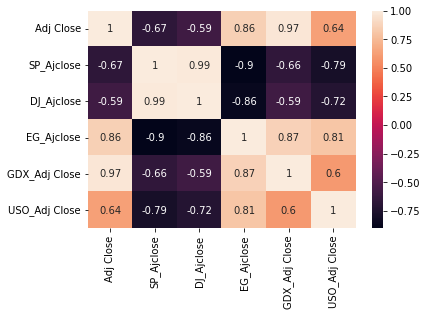

In [8]:
close_data = pd.DataFrame(df, columns = close_value)
correlation_mat = close_data.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

In [9]:
fig = go.Figure([go.Scatter(x=df['Date'], y=df['Adj Close'])])
fig.show()

In [10]:
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

## LSTM

In [13]:
pip install keras-layer-normalization

  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.15.0-py3-none-any.whl size=5224 sha256=ed7f20e1f16df03b2ff036020def31d18f6dc7c749f5f7ac071b60c796767b46
  Stored in directory: /root/.cache/pip/wheels/4d/be/fe/55422f77ac11fe6ddcb471198038de8a26b5a4dd1557883c1e
Successfully built keras-layer-normalization


In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
# from keras.layers.normalization import BatchNormalization
# from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
Adj_data = df.loc[:,close_value]

adj_close = Adj_data[['Adj Close']]

training_data_len = int(np.ceil( len(Adj_data) * .90 ))

sc = MinMaxScaler(feature_range = (0, 1))
scaled_data = sc.fit_transform(Adj_data)

sc1 = MinMaxScaler(feature_range = (0, 1))
sc_data = sc1.fit_transform(adj_close)

In [17]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 6))
# x_train.shape

In [18]:
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
  # output shape: (1, 1)
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [19]:
model = buildManyToOneModel(x_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(x_train, y_train, epochs=1000, batch_size=128, callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                680       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
12/12 [==============================] - 2s 29ms/step - loss: 0.1955
Epoch 2/1000
12/12 [==============================] - 0s 25ms/step - loss: 0.0781
Epoch 3/1000
12/12 [==============================] - 0s 25ms/step - loss: 0.0359
Epoch 4/1000
12/12 [==============================] - 0s 25ms/step - loss: 0.0187
Epoch 5/1000
12/12 [==============================] - 0s 27ms/step - loss: 0.0115
Epoch 6/1000
12/12 [==============================] - 0s 23ms/step - loss: 0.0055
Epoch 7/1000
12/12 [========

In [20]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = Adj_data['Adj Close'][training_data_len:].values
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])
    
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 6))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = sc1.inverse_transform(predictions)

In [21]:
t = np.linspace(0, len(y_test), len(y_test))
predictions = np.reshape(predictions,len(predictions))

fig = go.Figure()

fig.add_trace(go.Scatter(x=t, y=y_test,
                    mode='lines',
                    name='True data'))

fig.add_trace(go.Scatter(x=t, y=predictions,
                    mode='lines',
                    name='predict'))


fig.show()